# Initialization

In [3]:
%load_ext autoreload
%autoreload 2
from context import rmlib
import rmlib.rmtools as rm
from config import robotConfig

robot = rmlib.robot.Robot( robotConfig )

#Imports 
from time import sleep
import numpy as np
import rmlib
from rmlib.rmtools.assembly_trees.asm_tree_Basic import augment_RM

augment_RM( robot )

%store -r

####### LIBS #######################################################################################################################################

# Import Pytrees
import py_trees
from py_trees.tests import Timeout_Success
from py_trees.composites import Sequence , Selector
from py_trees.decorators import FailureIsSuccess , SuccessIsFailure

# import 
from rmlib.rmtools.assembly_trees.asm_tree_Basic import *

from rmlib.rmtools.assembly_trees.asm_tree_FT_based import ( 
    Bias_Wrist , Spiral_Insert , Tilt_Insert , Spin_Press , Move_to_Contact , SpiralStep
)
    
from rmlib.rmtools.assembly_trees.asm_tree_drill import *

from rmlib.rmtools.assembly_trees.asm_tree_logic_flow import Run_to_X_Failures_DECO

import math
from pmath import *

from utils import is_matx_list
from math import radians

print( "Libs loaded!" )

from task_parameters import taskParams , _TB_side , _M8_TB_height , _M6_TB_height , _M4_TB_height

_DRILL_CONTACT_PRESS = 11.0

import pickle , traceback

def save_names_to_PKL( pklPath , nameStringList ):
    pklStruct = {}
    print( vars() )
    for name in nameStringList:
        pklStruct[ name ] = globals()[ name ]
        
    with open( pklPath , "wb" ) as f:
        try:
            print( "Pickling" , pklPath , end = '... ' )
            pickle.dump( pklStruct , f )
            print( "Success!" )
        except Exception as er:
            print( "FAILURE! :" , er )
            traceback.print_exc()
    print( "### Completed Writing" , pklPath , "###" )
    
def load_names_from_PKL_to_global( pklPath , nameStringList ):
    n = 0
    with open( pklPath , "rb" ) as f:
        try:
            print( "Unpickling" , pklPath , end = '... ' )
            pklStruct = pickle.load( f )
            print( "Got: " , type( pklStruct ) , "with" , len( pklStruct ) , "elements" )
            globDict = globals()
            for name in nameStringList:
                try:
                    globals()[ name ] = pklStruct[ name ]
                    n += 1
                except:
                    print( "Could not load '" + str( name ) + "'! Continue ..." )
        except Exception as er:
            print( "FAILURE! :" , er )
            traceback.print_exc()
            
    print( "### Read" , n , "vars from" , pklPath , "into global dict ###" )

load_names_from_PKL_to_global( 
    pklPath = "taughtPoses.pkl" , 
    nameStringList = [  
        'M8_GraspPose' , 'M6_GraspPose' , 'M4_GraspPose' , 'GearShaft1_Setdown' , 'GearShaft2_Setdown' , 
        'BNC_Ma_Setdown' , 'KeySm_Setdown' , 'KeyLg_Setdown' , 'ShaftSm_Setdown' , 'ShaftLg_Setdown' , 
        'KeyLg_Grasp' , 'ShaftLg_Grasp' , 'BNC_Fe_Grasp' , 'ShaftSm_Grasp' , 
        'GearLg_Grasp' , 'GearLg_Grasp' , 'Ether_setdown' , 
        'M8_1_mag' , 'M8_2_mag' , 'M8_3_mag' , 'M8_4_mag' , 'M8_5_mag' , 'M8_6_mag' ,
        'M6_1_mag' , 'M6_2_mag' , 'M6_3_mag' , 'M6_4_mag' , 'M6_5_mag' , 'M6_6_mag' ,
        'M4_1_mag' , 'M4_2_mag' , 'M4_3_mag' , 'M4_4_mag' , 'M4_5_mag' , 'M4_6_mag' ,
        'releasePose' , 'SAFE_POSE' , 'midDrillPose' ,
        '_LRG_GEAR_DEX' , '_SML_GEAR_DEX', 'aboveTableDrill'
    ]
)

load_names_from_PKL_to_global( 
    pklPath = "dct.pkl" , 
    nameStringList = [ "dct" ]
)


## BIAS TEST ##
if 0:
    for i in range(40):
        print('##', i+1, '##')
        before = robot.ft.get_wrist_force()
        bgn    = time.time()
        robot.ft.bias_wrist_force()
        print( time.time() - bgn , "[s] bias time" )
        after  = robot.ft.get_wrist_force()
        print( after )
        print( "Diff:" , np.linalg.norm( np.subtract( after, before ) ) , '\n\n' )

Loading {'my_components': {'cam_config': {'pc_cam_offset': [-0.037, -0.033, -0.079], 'ci_cam_offset': [-0.036, -0.028, -0.079], 'class_name': 'RealSense', 'module_name': 'cameras.realsense', 'camera_model': 'd410'}, 'ft_config': {'filter': {'alpha': 0.012, 'beta': 0.035}, 'dataHz': 100.0, 'ip_address': '192.168.0.3', 'class_name': 'OptoForce', 'module_name': 'sensors.ftsensor_optoforce'}, 'hand_config': {'finger_length': 0.0415, 'finger_width_inner': 0.0, 'class_name': 'SmartHand', 'module_name': 'hands.smarthand', 'finger_width_outer': 0.015, 'finger_depth': 0.014}, 'arm_config': {'default_joint_speed': 0.7, 'xmlrpc_port': '8003', 'default_linear_speed': 0.1, 'default_joint_accel': 0.8, 'max_joint_speed': 1.05, 'max_joint_accel': 1.4, 'max_linear_speed': 0.25, 'max_linear_accel': 1.2, 'ip_address': '192.168.0.6', 'module_name': 'arms.ur5', 'default_linear_accel': 0.8, 'class_name': 'UR5'}}, 'active_components': {'camera': ['cam_config'], 'hand': ['hand_config'], 'ft': ['ft_config'], '

# Setup poses

In [26]:
# record coordinates of the E
E6=robot.arm.get_tcp_pose()

In [1]:
import pickle
# load coordinates of the E
with open('coords.pkl','rb') as f:  # Python 3: open(..., 'rb')
    E1, E2, E3, E4, E5, E6, SAFE_POSE, midDrillPose = pickle.load(f)

In [5]:
E2 = translate_pose( 
    E1 , 
    [ 0.0 , 0, -0.1 ] , # Translation vector
    dir_pose = 'origin' # { 'origin': lab frame, 'self': relative the argument pose }
)

In [27]:
# write coordinates of the E
with open('coords.pkl', 'wb') as f: 
    pickle.dump([E1, E2, E3, E4, E5, E6, SAFE_POSE, midDrillPose], f)

In [12]:
moveNode = Move_Arm( pose  = E1 , # 4x4 homogeneous coord pose
                     mode  = 'j' ,  # { 'l': linear in task space, 'j': linear in joint space }
                     speed = 0.125 , 
                     accel = 0.35 , 
                     ctrl  = robot ) # Ref to `rmlib` object, stored in `robot` in this NB

run_BT_until_done( moveNode )

### RUN BT Move_Arm ###

Root node Move_Arm failed!

--> Move_Arm [x]


Run completed! with status Status.FAILURE after 0.23369312286376953 seconds.



### BT SESSION OVER ###


# DEBUG Bad 'E' Poses

In [1]:
import pickle
# load coordinates of the E
with open('coords.pkl','rb') as f:  # Python 3: open(..., 'rb')
    E1, E2, E3, E4, E5, E6, SAFE_POSE, midDrillPose = pickle.load(f)

Loaded: /home/nvidia/dev_rmstudio/rmlib/rmlib/rmtools Exists?: True
Loaded: /home/nvidia/dev_rmstudio/rmlib Exists?: True
[[ 0.99850182  0.04715448  0.02775921 -0.07393497]
 [-0.03035611  0.05527973  0.99800935  0.72336297]
 [ 0.04552609 -0.99735681  0.05662833  0.4804411 ]
 [ 0.          0.          0.          1.        ]]
SINGULARITY CORRECTION APPLIED
[-0.07393497457386337, 0.723362974741358, 0.4804410987576419, -1.5143612005931313, -0.013483982653115635, -0.05882581509318319]
SINGULARITY CORRECTION APPLIED

[[ 0.99850868  0.0471206   0.02756941 -0.07404575]
 [-0.03017254  0.05545633  0.99800512  0.7233037 ]
 [ 0.04549771 -0.99734861  0.05679538  0.32996707]
 [ 0.          0.          0.          1.        ]]
SINGULARITY CORRECTION APPLIED
[-0.07404574738349513, 0.7233036979517822, 0.3299670692541624, -1.5141910987462321, -0.013605043264330674, -0.05865455883666198]
SINGULARITY CORRECTION APPLIED

[[ 0.99850321  0.04716822  0.02768569 -0.07399194]
 [-0.03028802  0.05538077  0.99800

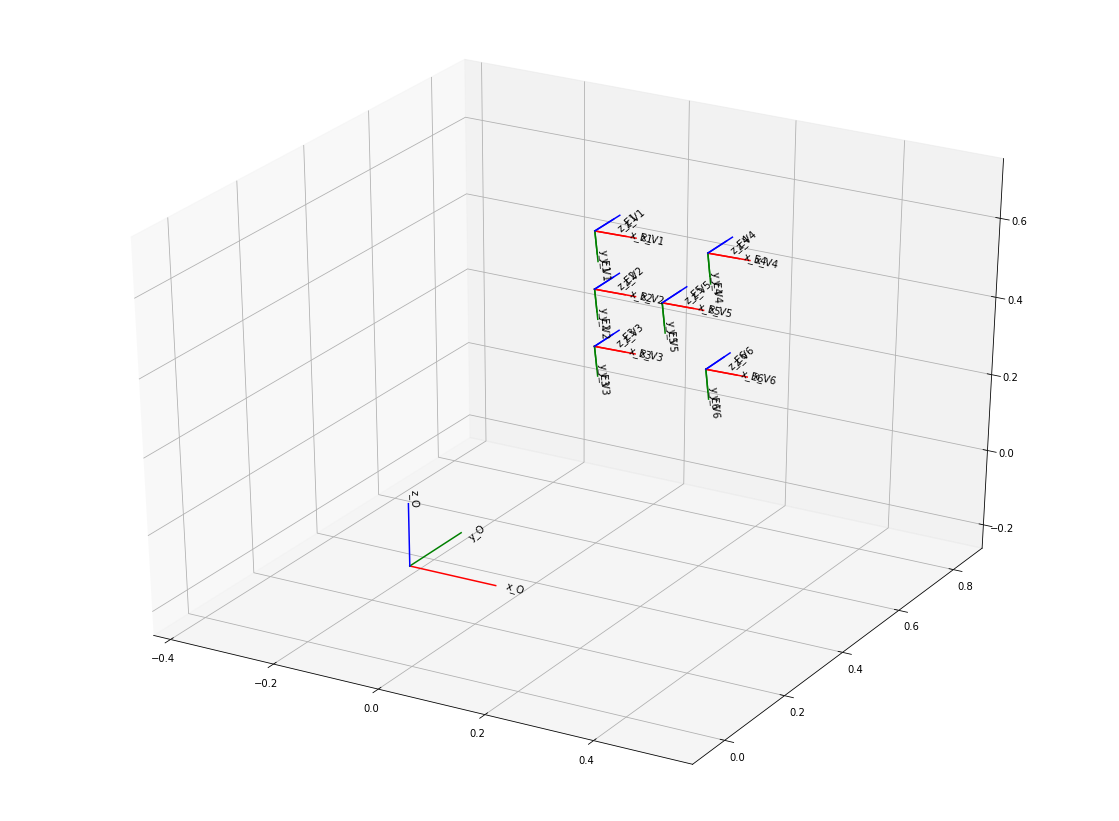

In [2]:
%matplotlib inline
from context import rmlib
from Plotting import *
from pmath import *
f = 1.65
fig,ax = fig_3d( [12*f,9*f] )

plot_pose_axes_mpl( ax , origin_pose() , 0.160 , labelStr = 'O' )

V = []

p_alt = 1

for i, pose in enumerate( [E1, E2, E3, E4, E5, E6] ):
    print( pose )
    plot_pose_axes_mpl( ax , pose , 0.060 , labelStr = 'E' + str(i+1) )
    print( pose_mtrx_to_vec( pose, alt = p_alt ) )
    if 1:
        plot_pose_axes_mpl( ax , 
                            pose_vec_to_mtrx( pose_mtrx_to_vec( pose, alt = p_alt ) ), 
                            0.080 , labelStr = 'V' + str(i+1) )
    print()
    
axes_equal( ax )
show_3d()

In [3]:
np.set_printoptions(precision=3,suppress=True)
robot.arm.get_tcp_pose()

array([[ 0.998,  0.047,  0.028, -0.074],
       [-0.03 ,  0.055,  0.998,  0.723],
       [ 0.046, -0.997,  0.057,  0.48 ],
       [ 0.   ,  0.   ,  0.   ,  1.   ]])

In [6]:
E1

array([[ 0.998,  0.047,  0.028, -0.074],
       [-0.03 ,  0.055,  0.998,  0.723],
       [ 0.046, -0.997,  0.057,  0.48 ],
       [ 0.   ,  0.   ,  0.   ,  1.   ]])

# Define BTs

In [99]:
robot.hand.deactivate_motors()

1

In [98]:
# Adjust this up in increments of 0.5-1.0 if you are having trouble picking up drill
_DRILL_CONTACT_PRESS = 12.0 # Too aggressive and holders move out of place over time

_LONG_DRILL_SAFE_Z = 0.250 # <-- VERY IMPORTANT - AVOID BREAKING DRILL

testTree =  Sequence( memory = 1 ) 

testTree.add_child(
    Unholster_Drill( 
    M4_GraspPose , 
    'M4' , 
    betweenPose = midDrillPose , 
    zApproach=0.20, zClose=0.040, zRetry=0.030 , Tpliant = 0.3 , 
    wdthNarrow = 0.038 , maxIter=5, drillPress = _DRILL_CONTACT_PRESS , 
    zFree=_LONG_DRILL_SAFE_Z , # <-- VERY IMPORTANT - AVOID BREAKING DRILL
    ctrl = robot 
    )
)

testTree.add_child(
    Jog_Safe( aboveTableDrill , # Destination
              zSAFE = _LONG_DRILL_SAFE_Z , # <-- VERY IMPORTANT - AVOID BREAKING DRILL
              hover = 1 , # Flag: remain at `zSAFE` instead of descending
              ctrl  = robot  )
)

testTree.add_child(
    Holster_Drill( 
        M4_GraspPose , 
        'M4' , 
        betweenPose = midDrillPose , 
        zApproach=0.20, 
        zClose=0.040, 
        Tpliant = 0.3 ,  
        wdthNarrow = 0.038 , maxIter=5, drillPress=_DRILL_CONTACT_PRESS , 
        zFree= _LONG_DRILL_SAFE_Z , # <-- VERY IMPORTANT - AVOID BREAKING DRILL
        driverLen = 0.160 ,
        ctrl = robot 
    )
)

run_BT_until_done( testTree , N = 90000 , 
                   tickPause = 0.25 , 
                   breakOnFailure = 1 , breakOnSuccess = 1 , 
                   Nverb = 100 )

### RUN BT Sequence ###

M4 checkout FAILED!
Root node Sequence failed!

[-] Sequence [x]
    [-] Unholster_Drill [x]
        --> Move_Arm [o]
        --> Move_Arm [o]
        --> Set_Grip_Torque [o]
        --> Set_Fingers [o]
        --> Move_Arm [o]
        --> Set_Fingers [o]
        --> Move_to_Contact [o]
        --> Set_Grip_Torque [o]
        [o] Recover_or_Quit [o]
            -^- Run_to_X_Failures_DECO [o]
                [o] Attached_Recover [o]
                    --> COND_Drill_Attached [o]
                    [-] Recovery_Sequence [-]
                        --> Set_Fingers [-]
                        --> Set_Grip_Torque [-]
                        --> Move_Arm [-]
                        --> Set_Fingers [-]
                        --> Move_to_Contact [-]
                        --> Set_Grip_Torque [-]
                        --> COND_Drill_Attached [-]
            [-] Give_Up [-]
                --> Set_Fingers [-]
                --> Move_Arm [-]
                --> Set

In [81]:
midDrillPose

array([[ 6.23318509e-04,  9.99998449e-01,  1.64720890e-03,
        -3.38585425e-01],
       [ 9.99999801e-01, -6.23481108e-04,  9.82003245e-05,
         1.46207684e-01],
       [ 9.92271759e-05,  1.64714736e-03, -9.99998639e-01,
         2.50281149e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [5]:
MoveAlongE = Sequence( memory = 1 ) 

MOVE_MODE = 'l'
MOVE_SPED = 0.063

MoveAlongE.add_child(
    Move_Arm( pose = E1 , mode = MOVE_MODE,  speed = MOVE_SPED , accel = 0.35 , ctrl = robot ) 
)

MoveAlongE.add_child(
    Move_Arm( pose = E2 , mode = MOVE_MODE,  speed = MOVE_SPED , accel = 0.35 , ctrl = robot ) 
)

MoveAlongE.add_child(
    Move_Arm( pose = E3 , mode = MOVE_MODE,  speed = MOVE_SPED , accel = 0.35 , ctrl = robot ) 
)

MoveAlongE.add_child(
    Move_Arm( pose = E4 , mode = MOVE_MODE,  speed = MOVE_SPED , accel = 0.35 , ctrl = robot ) 
)

MoveAlongE.add_child(
    Move_Arm( pose = E5 , mode = MOVE_MODE,  speed = MOVE_SPED , accel = 0.35 , ctrl = robot ) 
)

MoveAlongE.add_child(
    Move_Arm( pose = E6 , mode = MOVE_MODE,  speed = MOVE_SPED , accel = 0.35 , ctrl = robot ) 
)
run_BT_until_done( MoveAlongE )

### RUN BT Sequence ###

SINGULARITY CORRECTION APPLIED
SINGULARITY CORRECTION APPLIED
SINGULARITY CORRECTION APPLIED
SINGULARITY CORRECTION APPLIED
SINGULARITY CORRECTION APPLIED
SINGULARITY CORRECTION APPLIED
Root node Sequence succeeded!

[-] Sequence [o]
    --> Move_Arm [o]
    --> Move_Arm [o]
    --> Move_Arm [o]
    --> Move_Arm [o]
    --> Move_Arm [o]
    --> Move_Arm [o]


Run completed! with status Status.SUCCESS after 56.76905584335327 seconds.



### BT SESSION OVER ###


In [21]:
E1

array([[-0.99881199, -0.04734719, -0.01152589, -0.37359172],
       [-0.00975072, -0.03755404,  0.99924703,  0.83272686],
       [-0.04774439,  0.9981723 ,  0.03704775,  0.44679954],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

# Point Clouds

In [55]:
from cloud_proc.cloud_pipeline import Cloud_Pipeline
CPL = Cloud_Pipeline()

Cloud_Pipeline object created from components:  [<class 'cloud_proc.cloud_capturing.Cloud_Capturing'>, <class 'cloud_proc.cloud_poses.Cloud_Poses'>, <class 'cloud_proc.cloud_segmentation.Cloud_Segmentation'>, <class 'cloud_proc.cloud_processing.Cloud_Processing'>, <class 'cloud_proc.viewer_threejs.Viewer'>]


In [56]:
moveNode = Move_Arm( pose  = InspectPose , # 4x4 homogeneous coord pose
                     mode  = 'l' ,  # { 'l': linear in task space, 'j': linear in joint space }
                     speed = 0.125 , 
                     accel = 0.35 , 
                     ctrl  = robot ) # Ref to `rmlib` object, stored in `robot` in this NB

run_BT_until_done( moveNode )

### RUN BT Move_Arm ###

Root node Move_Arm succeeded!

--> Move_Arm [o]


Run completed! with status Status.SUCCESS after 0.23337960243225098 seconds.



### BT SESSION OVER ###


In [63]:
robot.camera.set_disparity_shift_dist( 0.3) # Fetch Z
# Capture pnt Cloud and transform to lab frame
cloudInLabFrame = transform_points( robot.camera.get_cloud() , robot.get_base_to_camera_pose() )

set_disparity_shift_dist: Got distance: 0.3 , Apply Offset: -0.079


In [64]:
view = CPL.PC_Viewer()
view.add_cloud( cloudInLabFrame )
view.show()

Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(-0.8932765477345904, 1.1220352283344195, 0.9…